In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import albumentations as A
import time
from sklearn.model_selection import StratifiedKFold

# Make dataset 

In [ ]:
### (32, 32)픽셀로 읽어 들이는데 19분
### 픽셀값 변경을 원할떄만 실행시키며 그렇지 않은 경우 아래의 joblib을 이용하여 가져올 것, 실행시간: 5초 이하
img_list=np.array([])
label_list=[]
for i in os.listdir(path):
    print("Progressing...")
    for j in os.listdir(os.path.join(path, i)):
        img = cv2.imread(os.path.join(path, i, j))
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_NEAREST)
        img = np.float32(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        img_list = np.append(img_list, img)
        label_list.append(i)
img_list = np.reshape(img_list, (-1, 32, 32, 3))

In [ ]:
joblib.dump(img_list, "CV2_float32.pkl")

In [ ]:
### (32, 32)픽셀로 읽어 들이는데 19분
### 픽셀값 변경을 원할떄만 실행시키며 그렇지 않은 경우 아래의 joblib을 이용하여 가져올 것, 실행시간: 5초 이하
img_list=np.array([])
label_list=[]
for i in os.listdir(path):
    print("Progressing...")
    for j in os.listdir(os.path.join(path, i)):
        img = cv2.imread(os.path.join(path, i, j))
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_LANCZOS4)
        img = np.float32(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        img_list = np.append(img_list, img)
        label_list.append(i)
img_list = np.reshape(img_list, (-1, 32, 32, 3))

In [ ]:
joblib.dump(img_list, "CV2_LANCZO.pkl")

In [ ]:
### (32, 32)픽셀로 읽어 들이는데 19분
### 픽셀값 변경을 원할떄만 실행시키며 그렇지 않은 경우 아래의 joblib을 이용하여 가져올 것, 실행시간: 5초 이하
img_list=np.array([])
label_list=[]
for i in os.listdir(path):
    print("Progressing...")
    for j in os.listdir(os.path.join(path, i)):
        img = keras.utils.load_img(os.path.join(path, i, j), target_size=(32, 32))
        img = np.float32(img)
        img = img/255.0
        img_list = np.append(img_list, img)
        label_list.append(i)
img_list = np.reshape(img_list,(-1, 32, 32, 3))

In [ ]:
joblib.dump(img_list, "converted_img.pkl")

# Import data and split

## cv2를 이용한 최근방 이웃, Lanczo, keras의 보간법을 사용하여<br> 같은 데이터를 3번 읽은 뒤 random_state를 고정한 상태에서 train과 test로 나누어 더함

In [2]:
X_train = []
X_test = []
y_train = []
y_test =[]

X = joblib.load("CV2_float32.pkl")
y = joblib.load("label.pkl")
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)
X_train.append(X_train_), y_train.append(y_train_), X_test.append(X_test_), y_test.append(y_test_)

X = joblib.load("converted_img.pkl")
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)
X_train.append(X_train_), y_train.append(y_train_), X_test.append(X_test_), y_test.append(y_test_)

X = joblib.load("CV2_LANCZO.pkl")
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)
X_train.append(X_train_), y_train.append(y_train_), X_test.append(X_test_), y_test.append(y_test_)

X_train = np.float32(X_train)
X_test = np.float32(X_test)
y_train = np.float32(y_train)
y_test = np.float32(y_test)
X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [3]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_train.reshape(-1, 1))

OneHotEncoder(sparse=False)

인코더는 증강 이후 사용

# Augmentation

## 50%확률로 수직, 수평으로 회전하는 증강 사용하여 10번 반복하여 데이터셋 증강

In [4]:
transform_fiip = A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5),
])

In [5]:
def make_train_data(augment):
    img_list = []
    label_list = []
    for _ in range(10):
        for i in range(len(X_train)):
            img_list.append(augment(image=X_train[i])["image"])
            label_list.append(y_train[i])
    img_list = np.float32(img_list)
    img_list = img_list.reshape(-1, 32, 32, 3)
    label_list = np.float32(label_list)
    return [img_list, label_list]

In [6]:
X_train, y_train = make_train_data(transform_fiip)

In [7]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_train.reshape(-1, 1))
y_train = encoder.transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# Train model 

## 조기종료: 5에포크, 학습률 감소: 3에포크 수렴 못할 시 0.001->0.00001까지 1/2<br>모델은 같은 크기(32, 32, 3)이미지에 사용된 Resnet20형태를 참고하여 생성

In [17]:
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, mode="max")
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.00001, verbose=1)
mc = keras.callbacks.ModelCheckpoint(filepath="./best_model.h5",monitor="val_loss", save_best_only=True, mode="min")

In [18]:
dr_ratio=0.2

Input = keras.layers.Input(shape=X_train[0].shape)

x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)

shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


x = keras.layers.Dropout(dr_ratio)(x)


shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)

shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)


x = keras.layers.GlobalAveragePooling2D()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

history=model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es, reduce_lr, mc],epochs = 100)
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
5119/5119 [==============================] - 59s 11ms/step - loss: 0.2442 - accuracy: 0.9040 - val_loss: 0.1001 - val_accuracy: 0.9639
Epoch 2/100
   6/5119 [..............................] - ETA: 53s - loss: 0.0498 - accuracy: 0.9792 

C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


5119/5119 [==============================] - 56s 11ms/step - loss: 0.0591 - accuracy: 0.9789 - val_loss: 0.1803 - val_accuracy: 0.9407
Epoch 3/100
5119/5119 [==============================] - 58s 11ms/step - loss: 0.0338 - accuracy: 0.9883 - val_loss: 0.1078 - val_accuracy: 0.9634
Epoch 4/100
5119/5119 [==============================] - 56s 11ms/step - loss: 0.0249 - accuracy: 0.9910 - val_loss: 0.0509 - val_accuracy: 0.9830
Epoch 5/100
5119/5119 [==============================] - 56s 11ms/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.0688 - val_accuracy: 0.9793
Epoch 6/100
5119/5119 [==============================] - 57s 11ms/step - loss: 0.0166 - accuracy: 0.9945 - val_loss: 2.2158 - val_accuracy: 0.7161
Epoch 7/100
5119/5119 [==============================] - 57s 11ms/step - loss: 0.0138 - accuracy: 0.9951 - val_loss: 0.0172 - val_accuracy: 0.9945
Epoch 8/100
5119/5119 [==============================] - 56s 11ms/step - loss: 0.0120 - accuracy: 0.9959 - val_loss: 1.4184 - val_

(0.0, 1.0)

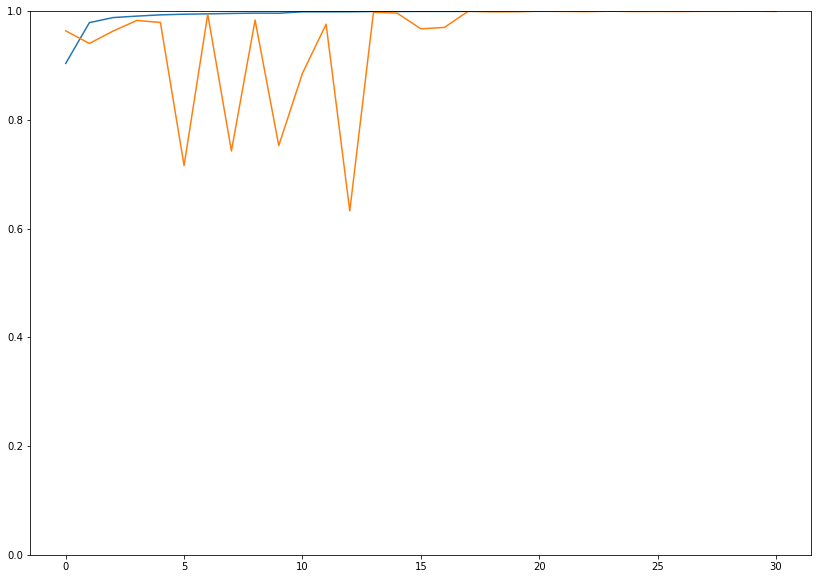

In [21]:
plt.figure(figsize=(14, 10))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylim(0.0, 1.0)

In [22]:
history.history["val_accuracy"]

[0.9639194011688232,
 0.9406593441963196,
 0.9633699655532837,
 0.9829670190811157,
 0.9793040156364441,
 0.7161172032356262,
 0.9945054650306702,
 0.7428571581840515,
 0.98369961977005,
 0.7527472376823425,
 0.8857142925262451,
 0.976007342338562,
 0.632600724697113,
 0.9979853630065918,
 0.9965201616287231,
 0.9675824046134949,
 0.9701465368270874,
 0.9998168349266052,
 0.9989010691642761,
 0.9990842342376709,
 1.0,
 0.9996336698532104,
 0.9992673993110657,
 1.0,
 0.9994505643844604,
 0.9996336698532104,
 0.9994505643844604,
 0.9998168349266052,
 0.9998168349266052,
 1.0,
 0.9996336698532104]